In [1]:
import torch

### Setup in google colab

In [2]:
# def format_pytorch_version(version):
#   return version.split('+')[0]
#
# TORCH_version = torch.__version__
# TORCH = format_pytorch_version(TORCH_version)
#
# def format_cuda_version(version):
#   return 'cu' + version.replace('.', '')
#
# CUDA_version = torch.version.cuda
# CUDA = "cpu"
#
# !pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-geometric
#

In [3]:
# !git clone https://github.com/funket/zorro.git
#

In [4]:
# !pwd
#

In [5]:
# %cd zorro/
#

In [6]:
# !pwd

In [7]:
from explainer import *
from models import *
import torch
import matplotlib.pylab as plt

# Data loading and GNN training

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset, data, results_path = load_dataset("Cora")
model = GCNNet(dataset)
model.to(device)
data = data.to(device)

In [9]:
train_model(model, data)

Accuracy: 0.3470
Accuracy: 0.7360
Accuracy: 0.7350
Accuracy: 0.7410
Accuracy: 0.7530
Accuracy: 0.7580
Accuracy: 0.7410
Accuracy: 0.7540


[]

# Gradient based explanation

In [10]:
from gnn_explainer import GNNExplainer

# GNNExplainer class needed for retrieval of computational graph
gnn_explainer = GNNExplainer(model, log=False)

explain_node = 0

In [11]:
def execute_model_with_gradient(model, node, x, edge_index):
    """Helper function, which mainly does a forward pass of the GNN"""
    ypred = model(x, edge_index)

    predicted_labels = ypred.argmax(dim=-1)
    predicted_label = predicted_labels[node]
    logit = torch.nn.functional.softmax((ypred[node, :]).squeeze(), dim=0)

    logit = logit[predicted_label]
    loss = -torch.log(logit)
    loss.backward()

In [12]:
def get_grad_node_explanation(model, node, data):
    """Calculates the gradient feature and node explanation"""

    # retrieve computational graph
    computation_graph_feature_matrix, computation_graph_edge_index, mapping, hard_edge_mask, kwargs = \
                                    gnn_explainer.__subgraph__(node, data.x, data.edge_index)
    # from now only work on the computational graph
    x = computation_graph_feature_matrix
    edge_index = computation_graph_edge_index

    # create a mask of ones which will be differentiated
    num_nodes, num_features = x.size()
    node_grad = torch.nn.Parameter(torch.ones(num_nodes, device=x.device))
    feature_grad = torch.nn.Parameter(torch.ones(num_features, device=x.device))
    node_grad.requires_grad = True
    feature_grad.requires_grad = True
    mask = node_grad.unsqueeze(0).T.matmul(feature_grad.unsqueeze(0))

    model.zero_grad()
    execute_model_with_gradient(model, mapping, mask*x, edge_index)

    node_mask = torch.abs(node_grad.grad).cpu().detach().numpy()
    feature_mask = torch.abs(feature_grad.grad).cpu().detach().numpy()

    return feature_mask, node_mask

In [13]:
grad_explanation = get_grad_node_explanation(model, explain_node, data)

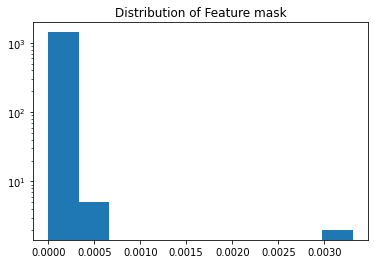

In [14]:
plt.title("Distribution of Feature mask")
plt.hist(grad_explanation[0])
plt.yscale("log")

##### Possible task: implementation of GradInput

# GNNExplainer

In [15]:
def get_gnn_explainer(node, data):
    feature_mask, edge_mask = gnn_explainer.explain_node(node, data.x, data.edge_index)
    return feature_mask, edge_mask

In [16]:
gnn_explanation = get_gnn_explainer(explain_node, data)

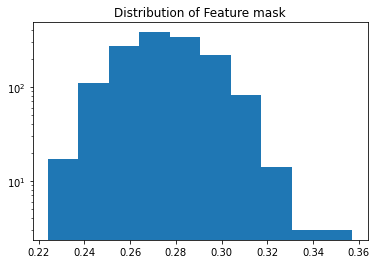

In [17]:
plt.title("Distribution of Feature mask")
plt.hist(gnn_explanation[0])
plt.yscale("log")

# Zorro

In [18]:
from explainer import Zorro

zorro = Zorro(model, device)
def get_zorro(node):
    # Same as the 0.98 in the paper
    tau = .03
    # only retrieve 1 explanation
    recursion_depth = 1

    explanation = zorro.explain_node(node, data.x, data.edge_index, tau=tau, recursion_depth=recursion_depth,)

    selected_nodes, selected_features, executed_selections = explanation[0]

    return selected_features[0], selected_nodes[0]

In [19]:
zorro_explanation = get_zorro(explain_node)


Argmax 19, 0.53: 100%|██████████| 1433/1433 [02:45<00:00,  8.66it/s]             

Explain node 0:   0%|          | 1/11464 [02:46<531:21:01, 166.87s/it]

0.27


Argmax 5, 0.10999999999999999: 100%|██████████| 8/8 [00:00<00:00,  8.56it/s]

Explain node 0:   0%|          | 2/11464 [02:47<220:44:23, 69.33s/it] 

0.38


Argmax 774, 0.13: 100%|██████████| 10/10 [00:01<00:00,  8.75it/s]               

Explain node 0:   0%|          | 3/11464 [02:49<122:56:08, 38.62s/it]

0.51


Argmax 507, 0.030000000000000027: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]

Explain node 0:   0%|          | 4/11464 [02:52<77:00:08, 24.19s/it] 

0.82


Argmax 507, 0.050000000000000044: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]

Explain node 0:   0%|          | 5/11464 [02:54<51:29:47, 16.18s/it]

0.92


Argmax 540, 0.039999999999999925: 100%|██████████| 10/10 [00:01<00:00,  7.99it/s]

Explain node 0:   0%|          | 6/11464 [02:55<36:05:56, 11.34s/it]

0.98


Explain node 0:   0%|          | 6/11464 [02:56<93:28:57, 29.37s/it]


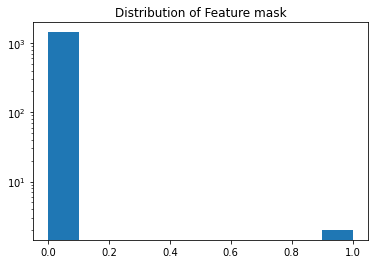

In [20]:
plt.title("Distribution of Feature mask")
plt.hist(zorro_explanation[0])
plt.yscale("log")

# SoftZorro

In [21]:
from explainer import SoftZorro

soft_zorro = SoftZorro(model, device)

def get_soft_zorro(node):
    node_mask, feature_mask = soft_zorro.explain_node(node, data.x, data.edge_index)
    return feature_mask[0], node_mask[0]

In [22]:
soft_zorro_explanation = get_soft_zorro(explain_node)

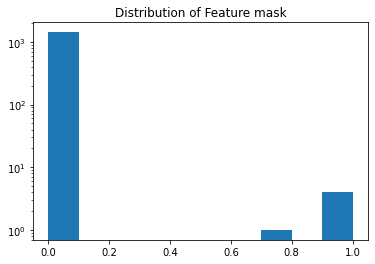

In [23]:
plt.title("Distribution of Feature mask")
plt.hist(soft_zorro_explanation[0])
plt.yscale("log")